In [4]:
import torch.nn as nn
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns
import os

In [5]:
np.random.seed(111)  # reproducibility
torch.cuda.is_available() 

True

In [6]:
# Enforcing GPU usage if available 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
# Loading file paths

#train_path = 'D:/DataScience/CMAPSS/Data/train_FD00X.txt'
#test_path = 'D:/DataScience/CMAPSS/Data/test_FD00X.txt'
#RUL_path = 'D:/DataScience/CMAPSS/Data/RUL_FD00X.txt'

train_path = f'E:/CMAPSS/data/train_FD00X.txt'
test_path = f'E:/CMAPSS/data/test_FD00X.txt'
RUL_path = f'E:/CMAPSS/data/RUL_FD00X.txt'


labels = ['unit', 'cycles', 'opMode1', 'opMode2', 'opMode3'] + [f'sensor{i}' for i in range(1, 22)]  # column headers, see readme file

In [14]:
# Function to load data and drop the columns specified by cols_to_drop, and add an RUL column for each unit
def load_data(filepath, rul=False):
    data = []
    # Creating lists which hold dataframes for each test trajectory
    if not rul:
        for i in range(1, 5):
            data.append(pd.read_csv(filepath.replace('X', str(i)),
                                    names=labels, delimiter='\s+',
                                    ))
        return data
    else:
        for i in range(1, 5):
            data.append(pd.read_csv(filepath.replace('X', str(i)),
                                    delimiter='\s+', header=None,
                                    ))

        return data  # a list


def prepare_data(train_data: pd.DataFrame):
    # Adds an RUL column for training
    ### TRAINING DATAFRAMES ###

    rul = pd.DataFrame(train_data.groupby('unit')['cycles'].max()).reset_index()
    rul.columns = ['unit', 'max']

    train_data = train_data.merge(rul, on=['unit'], how='left')

    train_data['RUL'] = train_data['max'] - train_data['cycles']
    train_data.drop('max', axis=1, inplace=True)

    return train_data

In [76]:
# Initialising data
train_data, test_data, RUL_data = load_data(train_path), load_data(test_path), load_data(RUL_path, True)

In [77]:
# Adding RUL columns 
for i in range(len(train_data)):
    train_data[i] = prepare_data(train_data[i])

In [ ]:
train_data[0]

We can observe, generally, the trend between the sensor readings and the RUL. Although the data is very noisy, the engines are all of the same make but only subject to different arbitrary conditions of wear and tear. We can go through a smaller subset of engine units, say 10 out of the 100. 


In [ ]:
train_data[0].describe()

Columns with a very low standard deviation can be ignored as it shows the values are roughly constant. Constant values do not have much bearing on machine learning methods.

In [78]:
def plot_sensor_reading(df, sensor_no):
    plt.figure(figsize=(12, 4))
    for i in df['unit'].unique():
        if (i % 10 == 0):  # 10 engines only (100 in total)
            plt.plot('RUL', sensor_no, data=df[df['unit'] == i].rolling(10).mean())
    plt.xticks(np.arange(0, 300, 25))
    plt.ylabel(f'Sensor {sensor_no} reading')
    plt.xlabel('Remaining useful life (RUL)')
    plt.show()

In [79]:
# Trajectories FD001 and FD003 both have redundant readings which can be dropped as they are constant or rarely change. FD004 and FD002 both have a redundant sensor 16.
cols_to_drop = ['opMode3', 'sensor1', 'sensor5',
                'sensor6', 'sensor10', 'sensor16',
                'sensor18', 'sensor19', 'sensor17']

train_data[0].drop(columns=cols_to_drop, inplace=True)
train_data[2].drop(columns=cols_to_drop, inplace=True)
test_data[0].drop(columns=cols_to_drop, inplace=True)
test_data[2].drop(columns=cols_to_drop, inplace=True)

train_data[1].drop(columns=['sensor16'], inplace=True)
train_data[3].drop(columns=['sensor16'], inplace=True)


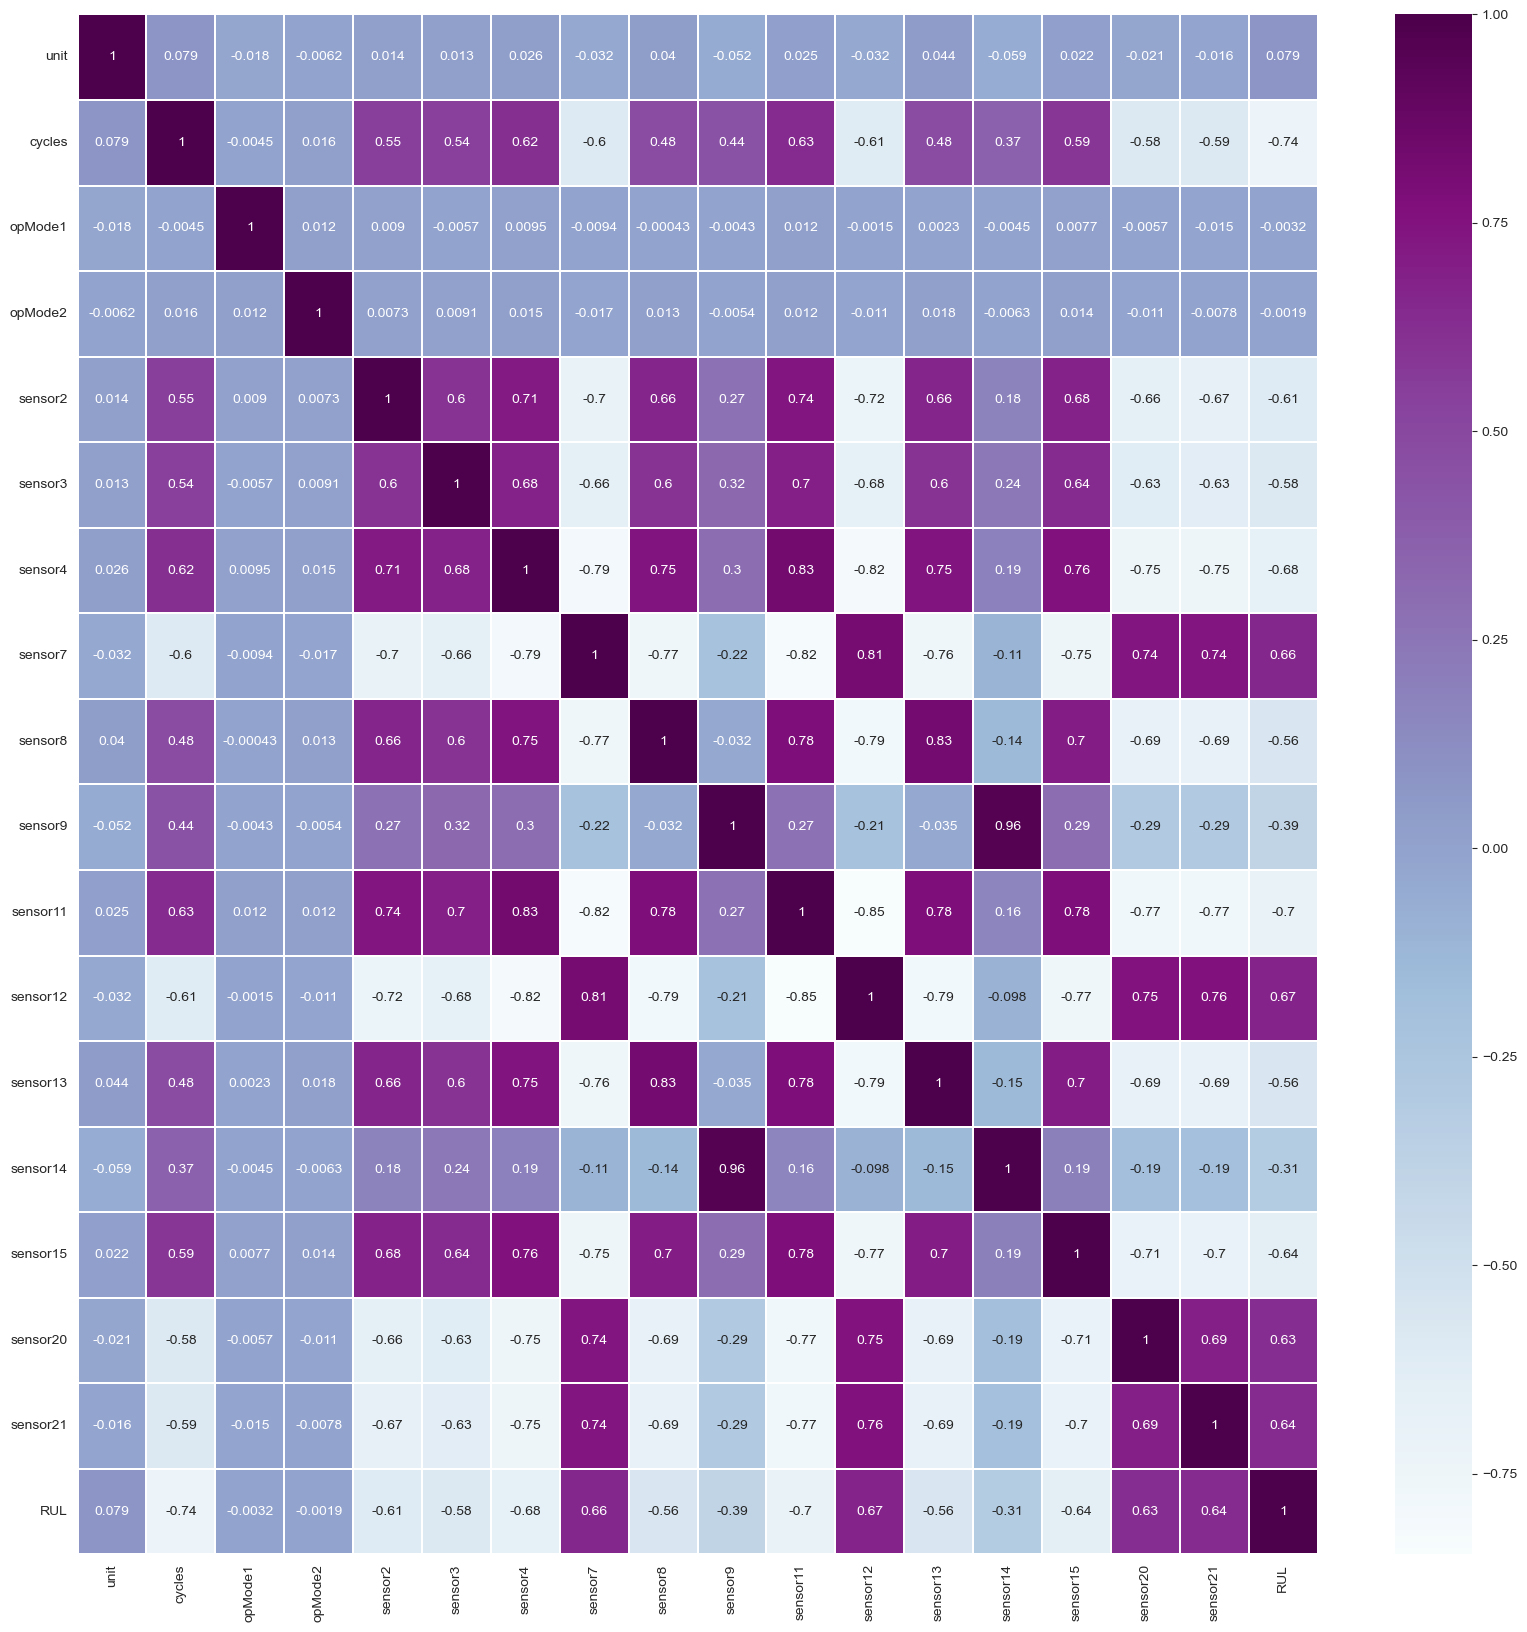

In [18]:
sns.heatmap(train_data[0].corr(), annot=True, cmap='BuPu', linewidths=0.2)
fig = plt.gcf()
fig.set_size_inches(20, 20)
plt.show()

In [80]:
# Removing properties with weak correlation and high inter-correlation
# sensor 14 and has aa very high correlation with sensor 9, we can remove sensor 14 to reduce multicollinearity
train_data[0].drop(columns=['opMode1', 'opMode2', 'sensor14'], inplace=True)
test_data[0].drop(columns=['opMode1', 'opMode2', 'sensor14'], inplace=True)
train_data[2].drop(columns=['opMode1', 'opMode2', 'sensor14'], inplace=True)
test_data[2].drop(columns=['opMode1', 'opMode2', 'sensor14'], inplace=True)

In [81]:
# Min-max scaling the data, except [cycles, RUL]
scaler = MinMaxScaler(feature_range=(-1, 1))

train_data[0].iloc[:, 2:-1] = scaler.fit_transform(train_data[0].iloc[:, 2:-1])
test_data[0].iloc[:, 2:] = scaler.transform(test_data[0].iloc[:, 2:])

train_data[2].iloc[:, 2:-1] = scaler.fit_transform(train_data[2].iloc[:, 2:-1])
test_data[2].iloc[:, 2:] = scaler.transform(test_data[2].iloc[:, 2:])


The data is extremely noisy. Here we apply a Savitzky-Golay filter to retain the trend and shape while smoothing out any noise with a window length equal to the number of cycles any given unit has lasted for.

In [82]:
from scipy.signal import savgol_filter as svg

In [83]:
# applying Savitzky-Golay to all sensor readings
def filter_readings(df):
    temp = df
    for i in df['unit'].unique():
        mask = df['unit'] == i
        masked = df[mask]
        if 'RUL' in masked.columns:
            for header, column in masked.drop(['unit', 'cycles', 'RUL'], axis=1).items():
                temp.loc[mask, header] = svg(column, window_length=len(column), polyorder=2)
        else:
            for header, column in masked.drop(['unit', 'cycles'], axis=1).items():
                temp.loc[mask, header] = svg(column, window_length=len(column), polyorder=2)
    return temp


In [84]:
a = filter_readings(train_data[0])

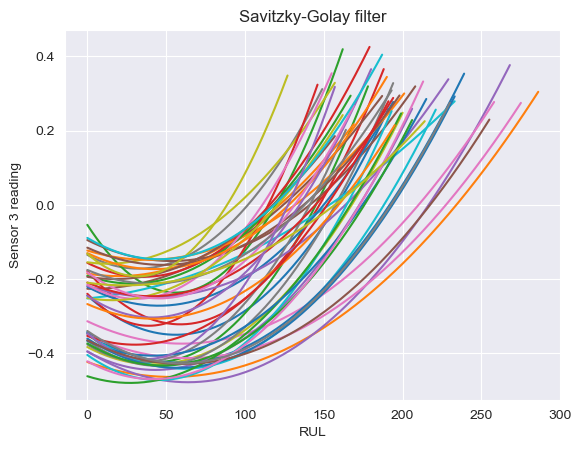

In [32]:
for i in range(1, 50):
    plt.plot(a[a['unit'] == i].reset_index()['sensor3'])
plt.title('Savitzky-Golay filter')
plt.xlabel('RUL')
plt.ylabel('Sensor 3 reading')
plt.show()


In [85]:
# Creating a training sequence
def create_training_sequence(df, seq_length, seq_cols):
    
    """function to prepare training data into (samples, time steps, features)
    df = training dataframe
    seq_length = look-back period
    seq_cols = feature columns"""

    data_array = df[seq_cols].values
    num_elements = data_array.shape[0]

    lstm_array = []

    for start, stop in zip(range(0, num_elements - seq_length + 1), range(seq_length, num_elements + 1)):
        lstm_array.append(data_array[start:stop, :])

    return np.array(lstm_array)

def create_target_sequence(df, seq_length, label):
    data_array = df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length - 1:num_elements + 1]


def create_training_batch(df, seq_length, columns):
    """Since the test data is stopped some arbitrary time before failure,
       the number of engine cycles won't necessarily be longer than a given window length,
       so we generate testing sequences which meet the sequence_length 
       """
    x = np.concatenate(
        list(list(create_training_sequence(df[df['unit'] == i], seq_length, columns)) for i in df['unit'].unique()))
    y = np.concatenate(
        list(list(create_target_sequence(df[df['unit'] == i], seq_length, 'RUL')) for i in df['unit'].unique()))
    return x, y


In [88]:
FD_columns = [[column for column in df if column != 'RUL'] for df in train_data]

[['unit',
  'cycles',
  'sensor2',
  'sensor3',
  'sensor4',
  'sensor7',
  'sensor8',
  'sensor9',
  'sensor11',
  'sensor12',
  'sensor13',
  'sensor15',
  'sensor20',
  'sensor21'],
 ['unit',
  'cycles',
  'opMode1',
  'opMode2',
  'opMode3',
  'sensor1',
  'sensor2',
  'sensor3',
  'sensor4',
  'sensor5',
  'sensor6',
  'sensor7',
  'sensor8',
  'sensor9',
  'sensor10',
  'sensor11',
  'sensor12',
  'sensor13',
  'sensor14',
  'sensor15',
  'sensor17',
  'sensor18',
  'sensor19',
  'sensor20',
  'sensor21'],
 ['unit',
  'cycles',
  'sensor2',
  'sensor3',
  'sensor4',
  'sensor7',
  'sensor8',
  'sensor9',
  'sensor11',
  'sensor12',
  'sensor13',
  'sensor15',
  'sensor20',
  'sensor21'],
 ['unit',
  'cycles',
  'opMode1',
  'opMode2',
  'opMode3',
  'sensor1',
  'sensor2',
  'sensor3',
  'sensor4',
  'sensor5',
  'sensor6',
  'sensor7',
  'sensor8',
  'sensor9',
  'sensor10',
  'sensor11',
  'sensor12',
  'sensor13',
  'sensor14',
  'sensor15',
  'sensor17',
  'sensor18',
  'sens

In [89]:
sequence_length = 15
trajectory = 0  # see readme file
batch_size = 200

In [90]:
FD001_train = filter_readings(train_data[trajectory])
FD001_test = filter_readings(test_data[trajectory])
FD001_truth = RUL_data[trajectory]

In [91]:
a, b = create_training_batch(FD001_train, sequence_length, FD_columns[trajectory])

In [92]:
feature_count = a.shape[1]  # feature count for CNN compatibility
feature_count_r = a.shape[2]  # feature count for SVM and random forests
out_dim = 1  # output dimension (1 RUL value)

In [93]:
x_train, x_val, y_train, y_val = train_test_split(a, b, test_size=0.3, random_state=42)

train_dataset = TensorDataset(torch.tensor(x_train, dtype=torch.float32),
                              torch.tensor(y_train, dtype=torch.float32).unsqueeze(1))
val_dataset = TensorDataset(torch.tensor(x_val, dtype=torch.float32),
                            torch.tensor(y_val, dtype=torch.float32).unsqueeze(1))

In [94]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [95]:
# Using the ground truth labels to create an RUL column in the test data
rul = pd.DataFrame(FD001_test.groupby('unit')['cycles'].max()).reset_index()
rul.columns = ['unit', 'max']
FD001_truth.columns = ['rulTruth']
FD001_truth['unit'] = np.arange(1, len(rul) + 1, 1)  # 100 units
FD001_truth['startLife'] = rul['max'] + FD001_truth['rulTruth']  # 
FD001_truth.drop(columns=['rulTruth'], inplace=True)

In [96]:
FD001_test = FD001_test.merge(FD001_truth, on=['unit'], how='left')
FD001_test['RUL'] = FD001_test['startLife'] - FD001_test['cycles']
FD001_test.drop('startLife', axis=1, inplace=True)

In [97]:
test_cols = list(FD001_test.columns[:-1])
x_test = create_training_sequence(FD001_test, sequence_length, test_cols)
x_test_tensor = torch.tensor(x_test).float().to(device)

# Model performance functions


In [98]:
def evaluation_metrics(ground_truth, prediction):
    print(f"Mean squared error: {mean_squared_error(ground_truth, prediction)}")
    print(f"Root mean squared error: {root_mean_squared_error(ground_truth, prediction)}")
    print(f"R2 score: {r2_score(ground_truth, prediction)}")
    print(f"Mean absolute error: {mean_absolute_error(ground_truth, prediction)}")
    return None


def loss_graphs(model):
    # expects a tuple of training and validation losses
    e = range(1, len(model[0]) + 1)  # the lists in the tuple are of equal length, can be model[1]
    plt.figure(figsize=(10,5))
    plt.plot(e, model[0], 'b', label='Training loss')
    plt.plot(e, model[1], 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.show()

In [99]:
x_train_reshaped = x_train.reshape(x_train.shape[0], sequence_length * feature_count_r)
x_val_reshaped = x_val.reshape(x_val.shape[0], sequence_length * feature_count_r)
x_test_reshaped = x_test.reshape(x_test.shape[0], sequence_length * feature_count_r)
start_idx = 2000
end_idx = 2900

truncated_ground_truth = FD001_test['RUL'][(sequence_length-1):].reset_index(drop=True)
truncated_subset = truncated_ground_truth[start_idx:end_idx].reset_index(drop=True)


# Using FLAML for automatic model selection


In [209]:
from flaml import AutoML

In [216]:
automl = AutoML()
automl.fit(x_train_reshaped, y_train, task='regression', time_budget=300)
automl.predict(x_test_reshaped, truncated_ground_truth)

[flaml.automl.logger: 07-29 19:04:40] {1680} INFO - task = regression
[flaml.automl.logger: 07-29 19:04:40] {1691} INFO - Evaluation method: holdout
[flaml.automl.logger: 07-29 19:04:40] {1789} INFO - Minimizing error metric: 1-r2
[flaml.automl.logger: 07-29 19:04:40] {1901} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth']
[flaml.automl.logger: 07-29 19:04:40] {2219} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 07-29 19:04:41] {2345} INFO - Estimated sufficient time budget=1600s. Estimated necessary time budget=11s.
[flaml.automl.logger: 07-29 19:04:41] {2392} INFO -  at 0.2s,	estimator lgbm's best error=0.6134,	best estimator lgbm's best error=0.6134
[flaml.automl.logger: 07-29 19:04:41] {2219} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 07-29 19:04:41] {2392} INFO -  at 0.4s,	estimator lgbm's best error=0.6134,	best estimator lgbm's best error=0.6134
[flaml.automl.logger: 07-29 19:04:41] {2219} IN

KeyboardInterrupt: 

In [213]:
from sklearn.ensemble import ExtraTreesRegressor

In [215]:
et_reg = ExtraTreesRegressor(n_estimators=124, n_jobs=-1, random_state=12032022, max_features=0.8158398621141937, max_leaf_nodes=6056)
et_reg.fit(x_train_reshaped, y_train)

ExtraTreesRegressor(max_features=0.8158398621141937, max_leaf_nodes=6056,
                    n_estimators=124, n_jobs=-1, random_state=12032022)

In [345]:
et_reg.score(x_test_reshaped, truncated_ground_truth)

ValueError: Found input variables with inconsistent numbers of samples: [13087, 13082]

In [346]:
y_hat = et_reg.predict(x_test_reshaped)

In [1]:
plt.plot(y_hat[0:1500])
plt.plot(truncated_ground_truth[0:1500])

NameError: name 'plt' is not defined